In [1]:
# importing important libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
msg = pd.read_csv('messages.csv', encoding='latin-1')
msg.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [3]:
msg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2831 non-null   object
 1   message  2893 non-null   object
 2   label    2893 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


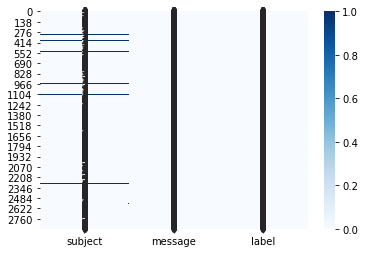

In [4]:
sns.heatmap(msg.isnull(),cmap="Blues", annot=True)
plt.show()

In [5]:
msg.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [6]:
print ('Shape = >',msg.shape)

Shape = > (2893, 3)


In [7]:
spam_msg = msg.copy()

In [8]:
spam_msg.dropna(axis=0,inplace=True)

In [9]:
print ('Shape = >',spam_msg.shape)

Shape = > (2831, 3)


In [10]:
spam_msg.isnull().sum()

subject    0
message    0
label      0
dtype: int64

In [11]:
print ('ham and spam counts', '\n',spam_msg.label.value_counts())

ham and spam counts 
 0    2363
1     468
Name: label, dtype: int64


In [12]:
# Convert all messages to lower case
spam_msg['subject'] = spam_msg['subject'].str.lower()
spam_msg['message'] = spam_msg['message'].str.lower()

In [13]:
# Replace email addresses with 'email'
spam_msg['subject'] = spam_msg['subject'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')
spam_msg['message'] = spam_msg['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

# Replace URLs with 'webaddress'
spam_msg['subject'] = spam_msg['subject'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')
spam_msg['message'] = spam_msg['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
spam_msg['subject'] = spam_msg['subject'].str.replace(r'£|\$', 'dollers')
spam_msg['message'] = spam_msg['message'].str.replace(r'£|\$', 'dollers')

# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
spam_msg['subject'] = spam_msg['subject'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')
spam_msg['message'] = spam_msg['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')
    
# Replace numbers with 'numbr'
spam_msg['subject'] = spam_msg['subject'].str.replace(r'\d+(\.\d+)?', 'numbr')
spam_msg['message'] = spam_msg['subject'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [14]:
# Remove punctuation
spam_msg['subject'] = spam_msg['subject'].str.replace(r'[^\w\d\s]', ' ')
spam_msg['message'] = spam_msg['message'].str.replace(r'[^\w\d\s]', ' ')
# Replace whitespace between terms with a single space
spam_msg['subject'] = spam_msg['subject'].str.replace(r'\s+', ' ')
spam_msg['message'] = spam_msg['message'].str.replace(r'\s+', ' ')
# Remove leading and trailing whitespace
spam_msg['subject'] = spam_msg['subject'].str.replace(r'^\s+|\s+?$', '')
spam_msg['message'] = spam_msg['message'].str.replace(r'^\s+|\s+?$', '')

In [15]:
spam_msg.head(5)

,subject,message,label
0,job posting apple iss research center,job posting apple iss research center,0
2,query letter frequencies for text identification,query letter frequencies for text identification,0
3,risk,risk,0
4,request book information,request book information,0
5,call for abstracts optimality in syntactic theory,call for abstracts optimality in syntactic theory,0


In [16]:
# Remove stopwords
import string
import nltk
from nltk.corpus import  stopwords

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

spam_msg['subject'] = spam_msg['subject'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))
spam_msg['message'] = spam_msg['message'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

In [17]:
#!pip install wordcloud
import warnings
warnings.filterwarnings('ignore')

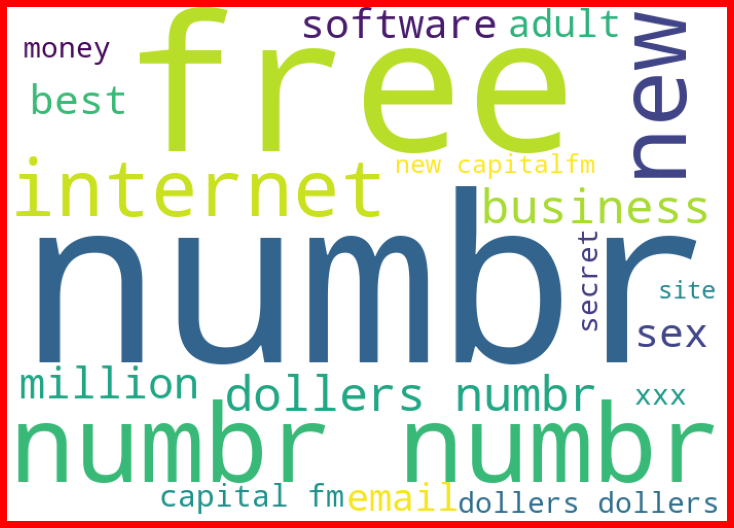

In [18]:
#Getting sense of loud words in spam 
from wordcloud import WordCloud


spams = spam_msg['message'][spam_msg['label']==1]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

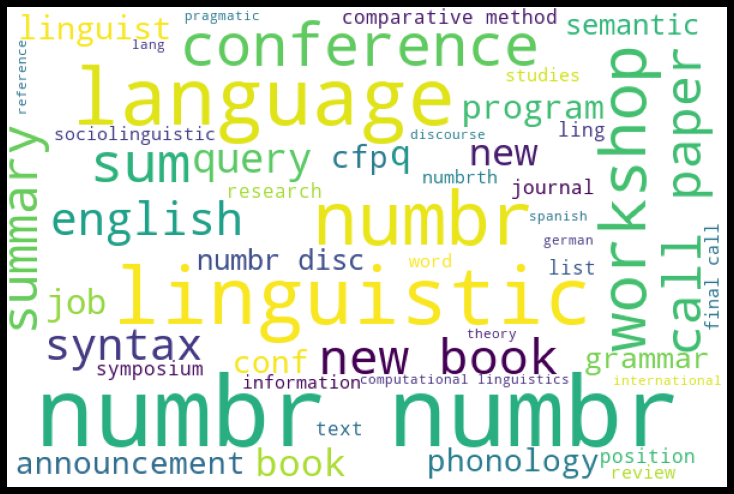

In [19]:
#Getting sense of loud words in ham 

hams = spam_msg['message'][spam_msg['label']==0]
spam_cloud = WordCloud(width=600,height=400,background_color='white',max_words=50).generate(' '.join(hams))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [20]:
# 1. Convert text into vectors using TF-IDF
# 2. Instantiate MultinomialNB classifier
# 3. Split feature and label
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tf_vec = TfidfVectorizer()

naive = MultinomialNB()

features = tf_vec.fit_transform(spam_msg['message'])

X = features
y = spam_msg['label']

In [21]:
# Train and predict
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)

naive.fit(X_train,Y_train)

y_pred= naive.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.8940677966101694


In [22]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       584
           1       1.00      0.40      0.57       124

    accuracy                           0.89       708
   macro avg       0.94      0.70      0.75       708
weighted avg       0.91      0.89      0.87       708



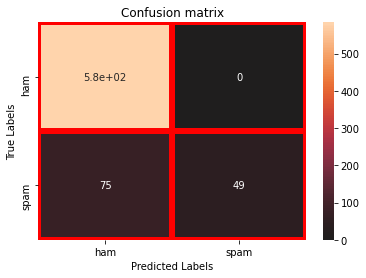

In [24]:
# plot confusion matrix heatmap
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['ham','spam'])
ax.yaxis.set_ticklabels(['ham','spam'])
plt.show()

In [25]:
conf_mat

array([[584,   0],
       [ 75,  49]], dtype=int64)